In [0]:
import os
import shutil
import matplotlib.image as mpimg
import random
import pandas as pd
import io
import requests

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd
#Copiando pasta de imagens para VM do google (testar também carregar diretamente do drive) --- Demora muito para carregar ~ 1 hora e meia
!rm -rf "tiny_img"
# !cp -r "/content/drive/My Drive/Colab Notebooks/tiny_img" ./tiny_img
!cp -r "/content/drive/My Drive/Colab Notebooks/imagens" ./tiny_img


/root


In [4]:
%cd
#armazenando nomes dos itens nas duas pastas: sem arma e com arma (base de dados original)
not_gun = os.listdir("tiny_img/all")
gun     = os.listdir("tiny_img/weapons")

/root


In [0]:
#Para o cenário em que usamos mais imagens contendo mãos, para melhorar desempenho:

In [0]:
!cp -r "/content/drive/My Drive/Colab Notebooks/imagens_novas/maos" ./tiny_img/all
!cp -r "/content/drive/My Drive/Colab Notebooks/imagens_novas/armas" ./tiny_img/weapons


In [7]:
%cd
#armazenando nomes dos itens nas duas pastas: sem arma e com arma -  base de dados estendida
not_gun_new_hands = os.listdir("tiny_img/all/maos")
gun_new_guns     = os.listdir("tiny_img/weapons/armas")



/root


In [8]:
# Sorteando de maneira aleatória e separando os conjuntos em Treino, Validação e Teste
img_format = "jpg"
n_samples_gun = 2950
# n_samples_gun = 40
prop_classes=1
train_fr = 0.6
val_fr = 0.2
test_fr  = 0.2

if(train_fr+val_fr+test_fr)!=1:
  print("Frações treino, validação e teste não somam 1.")

not_gun_shuff = not_gun.copy()
gun_shuff = gun.copy()

# selecionadno apenas imagens e no formato informado:
not_gun_shuff = [i for i in not_gun if i[-3:]==img_format]
gun_shuff     = [i for i in gun_shuff if i[-3:]==img_format]

# selecionando apenas imagens com 3 canais
not_gun_shuff = [i for i in not_gun_shuff if len(mpimg.imread("tiny_img/all"+"/"+i).shape)     == 3]
gun_shuff =     [i for i in gun_shuff     if len(mpimg.imread("tiny_img/weapons"+"/"+i).shape) == 3]

max_not_gun = len(not_gun_shuff)
max_yes_gun = len(gun_shuff)

#definindo numero de amostras

n_samples_all = min(n_samples_gun*prop_classes,max_not_gun) 
n_samples_gun = min(n_samples_gun,max_yes_gun) 

# embaralhando as ordens das imagens:
random.shuffle(not_gun_shuff)
random.shuffle(gun_shuff)

#Removendo pastas antigas (se houver)
!rm -rf "Train"
!rm -rf "Validation"
!rm -rf "Test"

#Criando pastas de Treino, Validação e Teste:
os.mkdir('Train')
os.mkdir('Validation')
os.mkdir('Test')

#Copiando e separando imagens em Treino/Validação/Teste e salvando em pastas separadas no VM:
dummy = [shutil.copyfile("tiny_img/all"    +"/"+i, "Train/"+i) for i in  not_gun_shuff[:int(n_samples_all*train_fr)]]
dummy = [shutil.copyfile("tiny_img/weapons" +"/"+i, "Train/"+i) for i in     gun_shuff[:int(n_samples_gun*train_fr)]]


dummy = [shutil.copyfile("tiny_img/all"    +"/"+i, "Validation/"+i) for i in  not_gun_shuff[int(n_samples_all*train_fr):int(n_samples_all*train_fr+n_samples_all*val_fr)]]
dummy = [shutil.copyfile("tiny_img/weapons" +"/"+i, "Validation/"+i) for i in     gun_shuff[int(n_samples_gun*train_fr):int(n_samples_gun*train_fr+n_samples_gun*val_fr)]]


dummy = [shutil.copyfile("tiny_img/all"    +"/"+i, "Test/"+i) for i in  not_gun_shuff[-int(n_samples_all*test_fr):]]
dummy = [shutil.copyfile("tiny_img/weapons" +"/"+i, "Test/"+i) for i in     gun_shuff[-int(n_samples_gun*test_fr):]]


print("• Train size: {}\n• Validation size:{}\n• Test size:{}".format(len( os.listdir('Train')),len( os.listdir('Validation')),len( os.listdir('Test'))))

print("\n Número de imagens em classe não_arma{}\nNúmero de imagens em classe arma:{}".format(n_samples_all,n_samples_gun))

• Train size: 3540
• Validation size:1180
• Test size:1180

 Número de imagens em classe não_arma2950
Número de imagens em classe arma:2950


In [9]:
%cd
#Salvando arquivo txt para armazenar nome das imagens a serem usadas como Teste após o treinamento
f= open("lista_img_test.txt","w+")
for imagem in  os.listdir("Test"):
  if imagem[-3:]==img_format:
    f.write("\n")
    f.write("img/"+imagem)
f.close()

/root


In [43]:
%cd 
#Rotina para adaptar label em XML para TXT formato Yolo
!git clone https://github.com/Isabek/XmlToTxt.git

/root
fatal: destination path 'XmlToTxt' already exists and is not an empty directory.


In [44]:
!pip install declxml

  Created wheel for declxml: filename=declxml-1.1.3-cp36-none-any.whl size=12295 sha256=924ce5dc4785b175b038917119125945bc902de60d29db764218ce6bed400179
  Stored in directory: /root/.cache/pip/wheels/b2/ca/2d/d7b9dcbac65b2c295b0ac99e2ddf326421d05a026c6794cbaf
Successfully built declxml


In [45]:
%cd 
#Copiando pasta de imagens para VM do google (testar também carregar diretamente do drive) --- Demora muito para carregar
!cp -r "/content/drive/My Drive/Colab Notebooks/WeaponS_bbox/WeaponS_bbox" ./WeaponS_bbox_xml

/root


In [0]:
#Removendo pastas antigas (se houver)
!rm -rf "WeaponS_bbox_xml_Train"
!rm -rf "WeaponS_bbox_xml_Validation"
!rm -rf "WeaponS_bbox_xml_Test"

#Criando pastas de xml localização Treino, Validação e Teste:
os.mkdir('WeaponS_bbox_xml_Train')
os.mkdir('WeaponS_bbox_xml_Validation')
os.mkdir('WeaponS_bbox_xml_Test')

In [0]:
#Copiando e separando xml das imagens em Treino/Validação/Teste e salvando em pastas separadas no VM:
dummy = [shutil.copyfile("WeaponS_bbox_xml/"+i[:-3]+"xml","WeaponS_bbox_xml_Train/"+i[:-3]+"xml") for i in  gun_shuff[:int(n_samples_gun*train_fr)]]

dummy = [shutil.copyfile("WeaponS_bbox_xml/"+i[:-3]+"xml","WeaponS_bbox_xml_Validation/"+i[:-3]+"xml") for i in  gun_shuff[int(n_samples_gun*train_fr):int(n_samples_gun*train_fr+n_samples_gun*val_fr)]]

dummy = [shutil.copyfile("WeaponS_bbox_xml/"+i[:-3]+"xml","WeaponS_bbox_xml_Test/"+i[:-3]+"xml") for i in  gun_shuff[-int(n_samples_gun*test_fr):]]


In [0]:
#Criando arquivo com as classes:
f= open("classes.txt","w+")
f.write("pistol") #temos apenas uma classe
f.close()

In [0]:
# Convertendo arquivo .xml de localização para o formato do yolo
!python XmlToTxt/xmltotxt.py -xml WeaponS_bbox_xml_Train      -out Train
!python XmlToTxt/xmltotxt.py -xml WeaponS_bbox_xml_Validation -out Validation
!python XmlToTxt/xmltotxt.py -xml WeaponS_bbox_xml_Test       -out Test



In [0]:
# %cd
# !zip -r "Train.zip" "Train"
# !zip -r "Validation.zip" "Validation"
# !zip -r "Test.zip" "Test"

# from google.colab import files

# files.download("Train.zip")
# files.download("Validation.zip")
# files.download("Test.zip")


In [0]:
# Criando arquivo vazio para imagens sem classe (sem armas):

for i in  not_gun_shuff[:int(n_samples_all*train_fr)]:
  f= open("Train/"+i[:-3]+"txt","w+")
  f.close()
for i in not_gun_shuff[int(n_samples_all*train_fr):int(n_samples_all*train_fr+n_samples_all*val_fr)]:
  f= open("Validation/"+i[:-3]+"txt","w+")
  f.close()
for i in  not_gun_shuff[-int(n_samples_all*test_fr):]:
  f= open("Test/"+i[:-3]+"txt","w+")
  f.close()



In [0]:
# Adicionando as imagens e labels novos às pastas

not_gun_new_hands_c = not_gun_new_hands.copy()
gun_new_guns_c      = gun_new_guns.copy()

# selecionadno apenas imagens e no formato informado:
not_gun_new_hands_c = [i for i in not_gun_new_hands_c if i[-3:]==img_format]
gun_new_guns_c     = [i for i in gun_new_guns_c if i[-3:]==img_format]

# selecionando apenas imagens com 3 canais:
not_gun_new_hands_c = [i for i in not_gun_new_hands_c if len(mpimg.imread("tiny_img/all/maos"+"/"+i).shape)      == 3]
gun_new_guns_c      = [i for i in gun_new_guns_c      if len(mpimg.imread("tiny_img/weapons/armas"+"/"+i).shape) == 3]



In [19]:
print("Novas imagens com mão: {}".format(len(not_gun_new_hands_c)))
print("Novas imagens com arma: {}".format(len(gun_new_guns_c)))


Novas imagens com mão: 1922
Novas imagens com arma: 545


In [0]:
train_fr = 0.6
val_fr = 0.2
test_fr  = 0.2


n_samples_hand_new = len(not_gun_new_hands_c)
n_samples_guns_new = len(gun_new_guns_c)

dummy = [shutil.copyfile("tiny_img/all/maos"      +"/" + i, "Train/"+i) for i in  not_gun_new_hands_c[:int(n_samples_hand_new*train_fr)]]
dummy = [shutil.copyfile("tiny_img/weapons/armas" +"/" + i, "Train/"+i) for i in     gun_new_guns_c[:int(n_samples_guns_new*train_fr)]]


dummy = [shutil.copyfile("tiny_img/all/maos"      +"/" + i, "Validation/"+i) for i in  not_gun_new_hands_c[int(n_samples_hand_new*train_fr):int(n_samples_hand_new*train_fr+n_samples_hand_new*val_fr)]]
dummy = [shutil.copyfile("tiny_img/weapons/armas" +"/" + i, "Validation/"+i) for i in     gun_new_guns_c[int(n_samples_guns_new*train_fr):int(n_samples_guns_new*train_fr+n_samples_guns_new*val_fr)]]


dummy = [shutil.copyfile("tiny_img/all/maos"      +"/" + i, "Test/"+i) for i in  not_gun_new_hands_c[-int(n_samples_hand_new*test_fr):]]
dummy = [shutil.copyfile("tiny_img/weapons/armas" +"/" + i, "Test/"+i) for i in     gun_new_guns_c[-int(n_samples_guns_new*test_fr):]]

In [21]:
print("Train: {}".format(len(os.listdir("Train"))))
print("Validation: {}".format(len(os.listdir("Validation"))))
print("Test: {}".format(len(os.listdir("Test"))))


Train: 6790
Validation: 2263
Test: 2263


In [24]:
# Adicionando as imagens e labels novos às pastas

%cd 
!rm -rf "Box_armas_novas"
#Copiando pasta de imagens para VM do google (testar também carregar diretamente do drive) --- Demora muito para carregar
!cp -r "/content/drive/My Drive/Colab Notebooks/box_armas" ./Box_armas_novas

/root


In [25]:
len(os.listdir("Box_armas_novas"))

561

In [0]:
# dummy = [shutil.copyfile("Box_armas_novas"      +"/" +i[:-3]+"txt", "Train/"+i[:-3]+"txt") for i in  not_gun_new_hands_c[:int(n_samples_hand_new*train_fr)]]
dummy = [shutil.copyfile("Box_armas_novas"      +"/" +i[:-3]+"txt", "Train/"+i[:-3]+"txt") for i in     gun_new_guns_c[:int(n_samples_guns_new*train_fr)]]


# dummy = [shutil.copyfile("Box_armas_novas"      +"/" +i[:-3]+"txt", "Validation/"+i[:-3]+"txt") for i in  not_gun_new_hands_c[int(n_samples_hand_new*train_fr):int(n_samples_hand_new*train_fr+n_samples_hand_new*val_fr)]]
dummy = [shutil.copyfile("Box_armas_novas"      +"/" +i[:-3]+"txt", "Validation/"+i[:-3]+"txt") for i in     gun_new_guns_c[int(n_samples_guns_new*train_fr):int(n_samples_guns_new*train_fr+n_samples_guns_new*val_fr)]]


# dummy = [shutil.copyfile("Box_armas_novas"      +"/" +i[:-3]+"txt", "Test/"+i[:-3]+"txt") for i in  not_gun_new_hands_c[-int(n_samples_hand_new*test_fr):]]
dummy = [shutil.copyfile("Box_armas_novas"      +"/" +i[:-3]+"txt", "Test/"+i[:-3]+"txt") for i in     gun_new_guns_c[-int(n_samples_guns_new*test_fr):]]


In [27]:
print("Train: {}".format(len(os.listdir("Train"))))
print("Validation: {}".format(len(os.listdir("Validation"))))
print("Test: {}".format(len(os.listdir("Test"))))


Train: 7117
Validation: 2372
Test: 2372


In [0]:
# Criando arquivo vazio para imagens sem classe (sem armas):

for i in  not_gun_new_hands_c[:int(n_samples_hand_new*train_fr)]:
  f= open("Train/"+i[:-3]+"txt","w+")
  f.close()
for i in not_gun_new_hands_c[int(n_samples_hand_new*train_fr):int(n_samples_hand_new*train_fr+n_samples_hand_new*val_fr)]:
  f= open("Validation/"+i[:-3]+"txt","w+")
  f.close()
for i in  not_gun_new_hands_c[-int(n_samples_hand_new*test_fr):]:
  f= open("Test/"+i[:-3]+"txt","w+")
  f.close()


In [50]:
print("Train: {}".format(len(os.listdir("Train"))))
print("Validation: {}".format(len(os.listdir("Validation"))))
print("Test: {}".format(len(os.listdir("Test"))))


Train: 10040
Validation: 3346
Test: 3346


In [30]:
%cd

/root


In [31]:
# Not Necessary cell
# List the content of your local computer folder 
!ls -la "/content/drive/My Drive/Colab Notebooks/darknet"

total 80289
-rw------- 1 root root    59415 Oct 16 17:24  5c3d48d20d2eb_armas.jpg
drwx------ 2 root root     4096 Oct 16 13:29  bin
drwx------ 2 root root     4096 Oct 16 11:45  cuDNN
-rw------- 1 root root 79327120 Nov 18 17:42 'darknet19_448.conv (2).23'
-rw------- 1 root root   455060 Oct  2 11:18  download.png
-rw------- 1 root root  2362011 Oct 16 17:26  ghostgun-03.jpg
-rw------- 1 root root     2179 Oct 16 16:48  TNL1BJN59-UNYSFDGLV-eba947f7160a-48.jpg


In [32]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (1,032 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure

In [33]:
!tree "/content/drive/My Drive/Colab Notebooks/darknet"

/content/drive/My Drive/Colab Notebooks/darknet
├── 5c3d48d20d2eb_armas.jpg
├── bin
│   └── darknet
│       └── darknet
├── cuDNN
│   ├── cudnn-10.0-linux-x64-v7.5.0.56.tgz
│   └── cudnn-10.0-linux-x64-v7.6.4.38.tgz
├── darknet19_448.conv (2).23
├── download.png
├── ghostgun-03.jpg
└── TNL1BJN59-UNYSFDGLV-eba947f7160a-48.jpg

3 directories, 8 files


In [34]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [35]:
# We're unzipping the cuDNN files from your Drive folder directly to the VM CUDA folders
!tar -xzvf /content/drive/My\ Drive/Colab\ Notebooks/darknet/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a


In [36]:
# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [37]:
# Leave this code uncommented on the very first run of your notebook or if you ever need to recompile darknet again.
# Comment this code on the future runs.
!git clone https://github.com/kriyeng/darknet/
%cd darknet



Cloning into 'darknet'...
remote: Enumerating objects: 10068, done.
remote: Total 10068 (delta 0), reused 0 (delta 0), pack-reused 10068
Receiving objects: 100% (10068/10068), 9.99 MiB | 9.91 MiB/s, done.
Resolving deltas: 100% (6762/6762), done.
/root/darknet


In [38]:
# Check the folder
!ls

# I have a branch where I have done the changes commented above
!git checkout feature/google-colab

#Compile Darknet
!make


#Copies the Darknet compiled version to Google drive
!cp ./darknet /content/drive/My\ Drive/Colab\ Notebooks/darknet/bin/darknet

3rdparty      CMakeLists.txt	      image_yolov3.sh	     scripts
appveyor.yml  CMakeSettings.json      include		     src
build	      DarknetConfig.cmake.in  json_mjpeg_streams.sh  video_v2.sh
build.ps1     darknet.py	      LICENSE		     video_yolov3.sh
build.sh      darknet_video.py	      Makefile
cfg	      data		      net_cam_v3.sh
cmake	      image_yolov2.sh	      README.md
Branch 'feature/google-colab' set up to track remote branch 'feature/google-colab' from 'origin'.
Switched to a new branch 'feature/google-colab'
mkdir -p obj
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(mat_cv*, detection*, int, float, char**, image**, in

In [39]:
%cd
#Criando obj.data:
f= open("darknet/obj.data","w+")
f.write("classes = 1")
f.write("\n")
f.write("train =  train.txt") 
f.write("\n")
f.write("valid =  valid.txt") 
f.write("\n")
f.write("names =  obj.names") 
f.write("\n")
f.write("backup = backup/") 

f.close()

f= open("darknet/obj.names","w+")
f.write("Arma") 
f.close()


/root


In [51]:
%cd

#Removendo pastas antigas (se houver)
!rm -rf "darknet/img"

os.mkdir('darknet/img')

f= open("darknet/train.txt","w+")
for imagem in  os.listdir("Train"):

  
  if imagem[-3:]==img_format:
    shutil.copyfile("Train/"+imagem, "darknet/img/"+imagem)
    shutil.copyfile("Train/"+imagem[:-3]+"txt", "darknet/img/"+imagem[:-3]+"txt")
    f.write("\n")
    f.write("img/"+imagem)
f.close()


f= open("darknet/valid.txt","w+")
for imagem in  os.listdir("Validation"):
  
  if imagem[-3:]==img_format:
    shutil.copyfile("Validation/"+imagem, "darknet/img/"+imagem)
    shutil.copyfile("Validation/"+imagem[:-3]+"txt", "darknet/img/"+imagem[:-3]+"txt")
    f.write("\n")
    f.write("img/"+imagem)
f.close()




/root


In [52]:
%cd darknet
!wget https://pjreddie.com/media/files/darknet53.conv.74

/root/darknet
--2019-12-04 19:53:37--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  19.2MB/s    in 9.2s    

2019-12-04 19:53:47 (16.9 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [53]:

%cd
# !cp -r "/content/drive/My Drive/Colab Notebooks/yolov3_gun_mod.cfg" ./darknet
!cp -r "/content/drive/My Drive/Colab Notebooks/yolov3_gun_mod_maxbatch6000.cfg" ./darknet
!cp -r "/content/drive/My Drive/Colab Notebooks/coco.names" ./darknet/data
%cd darknet

/root
/root/darknet


In [54]:
%cd 
%cd darknet

# Treinamento da rede Yolov3
!./darknet detector train "obj.data" "yolov3_gun_mod_maxbatch6000.cfg" "darknet53.conv.74" -dont_show 

/root
/root/darknet
yolov3_gun_mod_maxbatch6000
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x 

In [0]:
#algumas Utils que são uteis:
# imgShow() - Will help us to show an image in the remote VM
# download() - Will allow you to get some file from your notebook in case you need to
# upload() - You can upload files to your current folder on the remote VM.

#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

In [56]:
%cd
# Carregando os melhores pesos salvos após teste
!cp -r "/content/drive/My Drive/Colab Notebooks/yolov3_gun_mod_maxbatch6000_6000(1).weights" ./darknet

/root


/root
/root/darknet
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x

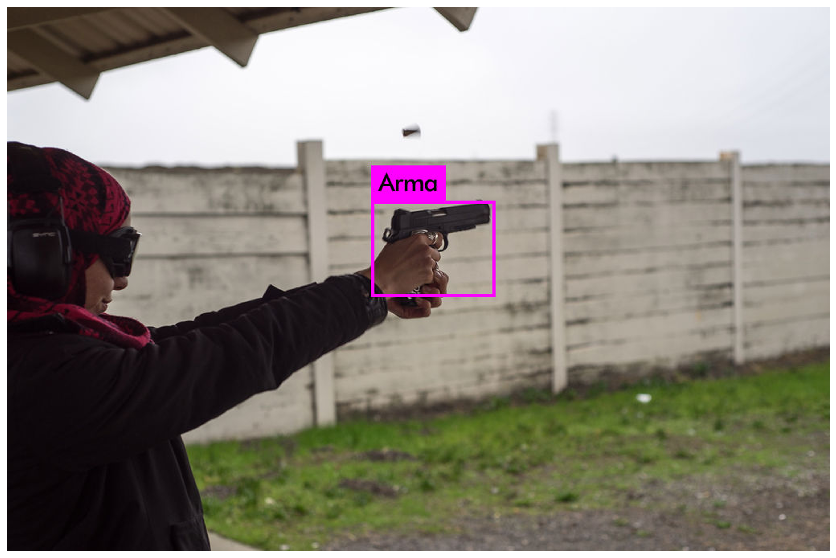

In [61]:
%cd
%cd darknet

# Testando para uma imagem  fora do conjunto de treino ou validação:
!./darknet detect yolov3_gun_mod_maxbatch6000.cfg "yolov3_gun_mod_maxbatch6000_6000(1).weights"  "/content/drive/My Drive/Colab Notebooks/todas_imagens_juntas/0caad617044daefb.jpg" -dont-show
imShow('predictions.jpg')
os.rename('predictions.jpg',"0caad617044daefb.jpg")
download("0caad617044daefb.jpg")